In [1]:
import torch
import transformers
from fastai.text.all import *
import fastai
import re
import os
from transformers import PreTrainedTokenizerFast,AutoModelWithLMHead
import chardet
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(transformers.__version__)
print( fastai.__version__)

c:\brain_tumor\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.5.1+cu118
4.47.0
2.7.18


In [2]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")

#test tokenizer
print(tokenizer.tokenize("안녕하세요. 한국어 GPT-2 입니다.😤:)l^o"))

#test model ouput
text = """성냥팔이 소녀는 추운 날씨에 성냥을 팔기 위해 나섰어요"""
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=128,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True
                        )
generated = tokenizer.decode(gen_ids[0,:].tolist())
print(generated)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
c:\brain_tumor\venv\Lib\site-packages\transformers\models\auto\modeling_auto.py:1838: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


['▁안녕', '하', '세', '요.', '▁한국어', '▁G', 'P', 'T', '-2', '▁입', '니다.', '😤', ':)', 'l^o']
성냥팔이 소녀는 추운 날씨에 성냥을 팔기 위해 나섰어요!
그런데 그게 웬일입니까?
아니, 저도 모르게, 아저씨가 갑자기 뭔가 이상한 소리를 하더군요.
"아, 아니야. 이거 뭐예요."
성냥 파는 가게의 주인은 아주머니에게 이렇게 말했습니다.
'뭐야, 이런 거 있잖소.'
그러자 손님은 깜짝 놀라며 고개를 끄덕였어요.
그리고 잠시 후, 주인 할머니께서 말씀하셨지요.
'이건 정말 장난이야! 네놈들이 왜 그렇게 많은 돈을 벌었지? 너희들은 모두 다 도둑질하고 있어."



In [3]:
def clean_text(text):
    text = re.sub(r"※.*", "", text)
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r'[^\w\sㄱ-힣,.!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'읽어주셔서 감사합니다', '', text)
    text = re.sub(r'동화 끝', '', text)
    text = re.sub(r'^\d+\.', '', text)
    text = re.sub(r'네이버지식인참조 네이버스캐스트영어동화열람불가 원문1819년 링크','',text)
    text = re.sub(r'네이버스캐스트영어동화열람불가','',text)
    text = re.sub(r'링크','',text)
    text = re.sub(r'링크','',text)
    return text

def split_sentences(text):
    sentences = re.split(r'(?<=[.!?])\s+', text)
    return [sent.strip() for sent in sentences if sent.strip()]

def preprocess_text(file_path):
    try:
        with open(file_path, 'rb') as f:
            result = chardet.detect(f.read())
        encoding = result['encoding']
        print(f"Detected encoding: {encoding}")

        with open(file_path, 'r', encoding=encoding) as f:
            text = f.read()

        print("File read successfully.")
        cleaned_text = clean_text(text)
        sentences = split_sentences(cleaned_text)

        return "\n".join(sentences)

    except Exception as e:
        print(f"Error: {e}")
        return ""

file_path = 'book.txt'

preprocessed_text = preprocess_text(file_path)
if preprocessed_text:
    print("Text preprocessing completed.")
else:
    print("Text preprocessing failed.")


Detected encoding: utf-8
File read successfully.
Text preprocessing completed.


In [4]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

train=preprocessed_text[:int(len(preprocessed_text)*0.9)]
test=preprocessed_text[int(len(preprocessed_text)*0.9):]
splits = [[0],[1]]

tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch,seq_len = 8,256
dls = tls.dataloaders(bs=batch, seq_len=seq_len)
# dls.show_batch(max_n=2)

c:\brain_tumor\venv\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs)


SuggestedLRs(valley=3.630780702224001e-05)


epoch,train_loss,valid_loss,perplexity,time
0,4.138207,3.968688,52.915085,00:53
1,3.863968,3.885596,48.695957,00:52
2,3.564215,3.876297,48.245255,00:53
3,3.270773,3.906835,49.741276,00:52
4,3.017443,3.930007,50.907345,00:52
5,2.798434,3.955456,52.219528,00:52
6,2.622091,3.986397,53.860493,00:53
7,2.486773,3.995488,54.352367,00:53
8,2.398636,3.995259,54.339890,00:53
9,2.359066,3.992496,54.189991,00:53


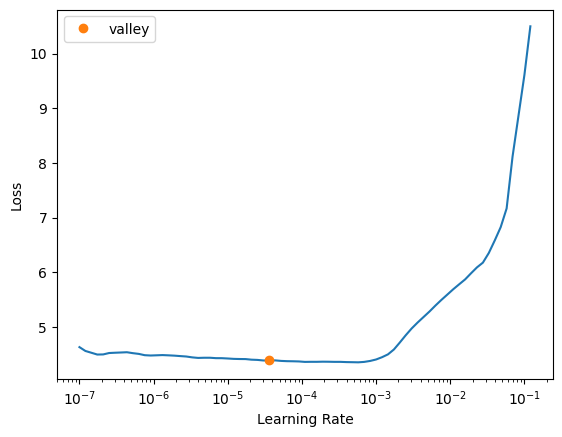

In [5]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]
        
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=[Perplexity()])

lr=learn.lr_find()
print(lr)
learn.fit_one_cycle(10, lr_max=lr)

# learn.fine_tune(3)    

In [6]:

def generate_text_and_split(prompt, model, tokenizer, max_length=128):
    prompt_ids = tokenizer.encode(prompt)
    inp = torch.tensor(prompt_ids)[None].to(device)
    gen_ids = model.generate(
        inp,
        max_length=max_length,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        bos_token_id=tokenizer.bos_token_id,
        repetition_penalty=2.0,
        use_cache=True,
    )
    generated = tokenizer.decode(gen_ids[0].cpu().numpy())
    sentences = split_sentences(generated)
    for sentence in sentences:
        print(sentence)
    
    return sentences


prompt = """성냥팔이 소녀는 추운 날씨에 성냥을 팔기 위해 나섰어요"""
generated_sentences = generate_text_and_split(prompt, model, tokenizer)


성냥팔이 소녀는 추운 날씨에 성냥을 팔기 위해 나섰어요원문소년의 할머니 집을 지나갈 때면 항상 이렇게 말하곤 했어요.
할머니, 이게 다 무슨 일이랍니까?
그럼요,라며 소년은 대답했어요.
하지만 그건 네가 한 번 더 외출할 때마다 하는 소리였지요.
너를 따뜻하게 해주마.
그래서 그녀는 밖으로 나가 땔감을 구하러 숲으로 들어갔답니다.
숲에서 가장 가까이에 있는 오두막집에 도착해 보니 거기엔 모두들 잠들어 있었죠.
오두막은 온통 금으로 만들어져 있었고 벽난로 위에는 은과 금을 상징하는 글씨체로 된 큰 홀 하나가 서 있었는데, 아무도 눈을


In [7]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[Perplexity()])

In [8]:
learn.model.save_pretrained("kogpt2novel_backup")